(sec-discocirc_training)=

# Question answering with DisCoCirc: following dataset

This notebook details an example setup to replicate the work in [Duneau et al. 2024](http://arxiv.org/abs/2409.08777), constructing the following dataset and training a quantum model.


{download}`⬇️ Download code <../_code/discocirc-following.ipynb>`

### The Dataset

The dataset consists of a series of stories about a selection of actors. The actors are initialised to face one of the cardinal directions - we pick either two or four of these to control the complexity of the task - and may then either turn around by themselves or interact with other actors to change direction. We understand the events to be instantaneous - if Bob follows Alice and Alice subsequently turns around, Bob does not also turn around himself, but rather stays facing Alice's original direction.
At the end of the story, we select two actors, and ask the model if they are facing the same direction. A simple story might be as follows:

```
Alice walks North.
Bob walks South.
Alice turns around.
Bob follows Alice.
```

To construct the dataset, we will randomly generate stories of this form.
While the lambeq parser could be used to construct the DisCoCirc diagrams, we apply rewrites that make it straightforward to generate the required diagrams directly, and hence bypass the parsing step.

In [1]:
# Imports and constants
import random
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

from lambeq import CachedTnPathOptimizer, PytorchTrainer

from utils.following.generate_stories import generate_stories
from utils.following.parser import FollowingParser
from utils.ansatz import DiscardSim4Ansatz, PersonFunctor
from utils.training import QADataset, PytorchQAModel

SAVE_DIR = Path("./results/following").resolve()
SAVE_DIR.mkdir(parents=True, exist_ok=True)
SAVE_DIR

PosixPath('/Users/tiffany.duneau/PycharmProjects/QDisCoCirc_Following_Showcase/tutorials/results/following')

In [2]:
# Random seed
SEED = 42

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

Story generation is controlled by two classes: `Actor`s track the state of each actor throughout the story, and provide the sentences for each action.
The `Story` class holds a selection of named actors, and contains two sampling methods for generating a story:
- `generate_dense` generates a story with a controlled proportion of single actor sentences interspersed between two actor sentences. The two-actor sentences are sampled without replacement from all possible two-actor interactions available.
- `generate` generates a story incrementally, where each sentence is sampled independently, with replacement, where the probability of sampling a single actor sentence is controlled.

In the paper, the `simple` and `deeper` datasets were sampled using the `generate` method, whilst `less-dense`, `dense` and `superdense` datasets were sampled using `generate_dense`. Here we omit the `deeper` setting, as it differed from `simple` only in the story shapes, rather than generation probabilities.

In [9]:
# Dataset generation variables
min_actors = 2
max_actors = 8
min_sents = 2
max_sents = 20  # Must be at least max_actors, as all actors require at least one sentence to be initialized.
n_samples = 2
n_directions = 4  # 2 or 4
density = "dense" # simple, less-dense, dense, superdense
with_axioms = True  # Apply simplifying axioms to reduce the number of parameters

In [10]:
# Generate the stories
stories = generate_stories(
    min_actors=min_actors, max_actors=max_actors,
    min_sentences=min_sents, max_sentences=max_sents,
    density=density,
    n_samples=n_samples, n_directions=n_directions,
)

with open(SAVE_DIR / "stories.pkl", "wb") as f:
    pickle.dump(stories, f)

Generating stories: 100%|██████████| 7/7 [00:00<00:00, 270.60it/s]


The above generated the stories as text; we must now parse these and convert them into quantum circuits.

As we are not intending to use frames, we shall parse these directly, without reference to the DisCoCirc parser in `lambeq`.
One of the axioms applied is to remove individual names, replacing these with the word `person`. We apply this once the diagrams have been generated, as the wires will now capture the identity of each actor, rendering their names redundant for the purposes of this task.

We are now ready to construct the ansatz. We wrap the basic `lambeq` ansatz with custom code to handle daggered boxes, as well as `DISCARD` boxes.
Following the paper, we select the `Sim4` ansatz, with one ancilla wire for the `follows` box.



In [11]:
# User ansatz params
n_qb_per_actor = 1
n_layers = 3
following_ancillas = True

In [12]:
# Define the ansatz
parser = FollowingParser(n_directions=n_directions, with_axioms=with_axioms)
ansatz = DiscardSim4Ansatz(
    ob_map={parser.n: n_qb_per_actor},
    n_layers=n_layers,
    discard=True,
    n_ancillas={parser.follows: 1, parser.goes_opdir: 1} if following_ancillas else 0,
)

In [13]:
# Parse and flatten into a list
def convert_functor(diagram):
    diag = PersonFunctor(diagram)
    return ansatz(diag)

def parse_diag(story, actor1, actor2, answer, dir1, dir2, entangled, n_actors, n_sentences):
    context_diag = parser.parse(story, actor1, actor2)
    context_circ = convert_functor(context_diag)

    yes_diag = parser.get_ques_diag(nouns=True, higher_order=False)
    no_diag = parser.get_ques_diag(negative=True, nouns=True, higher_order=False)

    yes_circ = context_circ >> convert_functor(yes_diag).dagger()
    no_circ = context_circ >> convert_functor(no_diag).dagger()

    return {
        "story": story,
        "n_actors": n_actors,
        "n_sentences": n_sentences,
        "directions": (dir1, dir2),
        "entangled": entangled,
        "answer_class": "yes" if answer else "no",
        "actors": (actor1, actor2),
        "diags": (context_diag, yes_diag, no_diag),
        "circuits": [yes_circ, no_circ],
        "target": torch.tensor([1, 0] if answer else [0, 1], dtype=torch.float32),
    }

dataset = [
    parse_diag(**story, n_actors=n_acts, n_sentences=n_sents)
    for (n_acts, n_sents) in stories.keys()
    for ans_class in stories[(n_acts, n_sents)].keys()
    for story in stories[(n_acts, n_sents)][ans_class]
]

with open(SAVE_DIR / "circuits.pkl", "wb") as f:
    pickle.dump(dataset, f)

len(dataset)

408

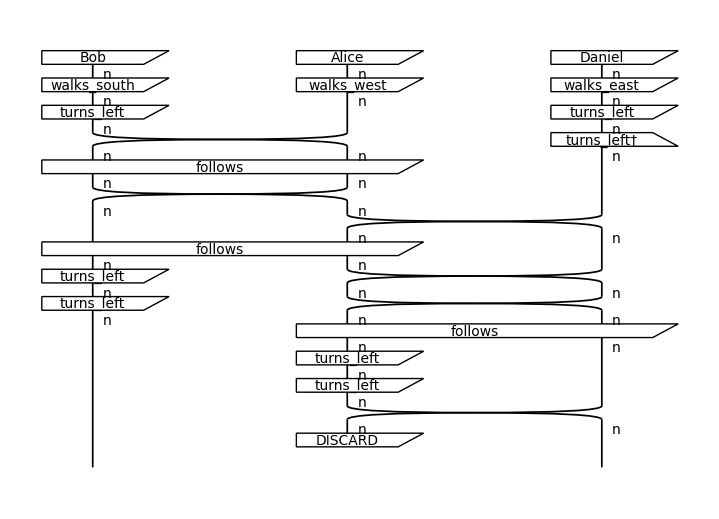

(['Bob walks south. ',
  'Alice walks west. ',
  'Daniel walks east. ',
  'Daniel turns left. ',
  'Daniel turns right. ',
  'Bob turns left. ',
  'Alice follows Bob. ',
  'Bob goes in the opposite direction of Daniel. ',
  'Daniel goes in the opposite direction of Alice. '],
 3,
 17,
 ('Bob', 'Daniel'),
 'yes',
 ('west', 'west'),
 'entangled: False')

In [14]:
# Inspect the generated circuits.

inspect_index = 101
dataset[inspect_index]["diags"][0].draw(figsize=(7, 5))
# (dataset[inspect_index]["diags"][1] @ dataset[inspect_index]["diags"][2]).draw(figsize=(5, 3))
# dataset[inspect_index]["circuits"][0].draw(figsize=(7, 7))
# print(sorted(dataset[inspect_index]["circuits"][0].free_symbols))
(
    dataset[inspect_index]["story"],
    dataset[inspect_index]["n_actors"],
    dataset[inspect_index]["n_sentences"],
    dataset[inspect_index]["actors"],
    dataset[inspect_index]["answer_class"],
    dataset[inspect_index]["directions"],
    f'entangled: {dataset[inspect_index]["entangled"]}',
)

### Data split

Recall that our goal is to test compositional generalisation. This means we must train the model on small stories, and test to see whether it can generalise to longer stories.

The split presented here is somewhat crude; a more sophisticated approach would include some overlap between the distributions to verify overfitting.

In [15]:
# User params
batch_size = 1

train_size = 0.5
valid_size = 0.75

n_actor_train_cutoff = 5
n_actor_valid_cutoff = 7

In [16]:
train_threshold = min_sents + train_size * (max_sents - min_sents)
valid_threshold = min_sents + valid_size * (max_sents - min_sents)

train_ids = [
    i for i, entry in enumerate(dataset)
    if entry["n_sentences"] < train_threshold and entry["n_actors"] < n_actor_train_cutoff
]
valid_ids = [
    i for i, entry in enumerate(dataset)
    if entry["n_sentences"] >= train_threshold and entry["n_actors"] >= n_actor_train_cutoff
    and entry["n_sentences"] < valid_threshold and entry["n_actors"] < n_actor_valid_cutoff
]
test_ids = [
    i for i, entry in enumerate(dataset)
    if entry["n_sentences"] >= valid_threshold and entry["n_actors"] >= n_actor_valid_cutoff
]
other_ids = [
    i for i in range(len(dataset))
    if i not in train_ids + valid_ids + test_ids
]

train_dataset = QADataset(
    data=[entry["circuits"] for i, entry in enumerate(dataset) if i in train_ids],
    targets=[entry["target"] for i, entry in enumerate(dataset) if i in train_ids],
    batch_size=batch_size, shuffle=True
)
valid_dataset = QADataset(
    data=[entry["circuits"] for i, entry in enumerate(dataset) if i in valid_ids],
    targets=[entry["target"] for i, entry in enumerate(dataset) if i in valid_ids],
    batch_size=0, shuffle=False
)
test_dataset = QADataset(
    data=[entry["circuits"] for i, entry in enumerate(dataset) if i in test_ids],
    targets=[entry["target"] for i, entry in enumerate(dataset) if i in test_ids],
    batch_size=0, shuffle=False
)

len(train_dataset), len(valid_dataset), len(test_dataset), len(other_ids)

(96, 40, 40, 232)

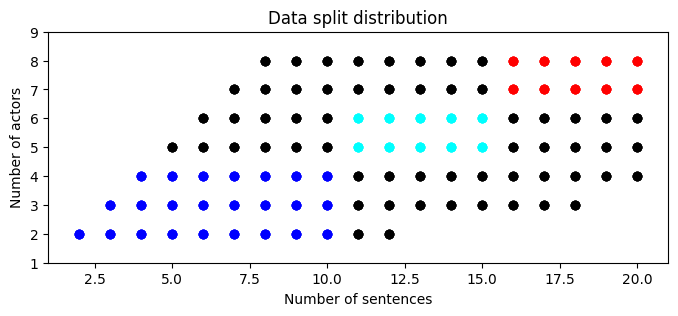

In [17]:
# Visualise the data split distribution
fig, ax = plt.subplots(figsize=(8,3))
ax.set_title('Data split distribution')
ax.set_xlabel('Number of sentences')
ax.set_ylabel('Number of actors')
ax.set_xlim(min_sents-1, max_sents+1)
ax.set_ylim(min_actors-1, max_actors+1)

shapes = list(stories.keys())

for ids, col in zip([train_ids, valid_ids, test_ids, other_ids], ["blue", "cyan", "red", "black"]):
    ax.scatter(
        x=[entry["n_sentences"] for i, entry in enumerate(dataset) if i in ids],
        y=[entry["n_actors"] for i, entry in enumerate(dataset) if i in ids],
        c=col
    )

## Training

Now that we have generated the data, let us implement the training.
We use `lambeq`'s `PytorchQuantumTrainer` class to train using classical simulation via tensor network evaluation. This allows us to compute gradients analytically through the circuits while remaining more tractable than a statevector simulation.

We subclass `PytorchQuantumModel` for our model class in order to handle pairs of circuits.
We interpret the model's output as a probability distribution over the possible answers `[yes, no]`, and evaluate it accordingly.

In [18]:
n_epochs = 40
learning_rate = 5e-3
training_seed = 420

In [19]:
def acc(batched_y_hat: torch.tensor, batched_y: torch.tensor) -> torch.tensor:
    argmax_y_hat = torch.argmax(batched_y_hat, dim=1)
    argmax_y = torch.argmax(batched_y, dim=1)
    accs = argmax_y_hat == argmax_y
    return torch.mean(accs, dtype=torch.float)

In [20]:
model = PytorchQAModel.from_diagrams(
    diagrams=train_dataset.data + valid_dataset.data + test_dataset.data,
    tn_path_optimizer=CachedTnPathOptimizer(save_file=Path(SAVE_DIR / "tn_cache.pkl"))
)
model.initialise_weights()

trainer = PytorchTrainer(
    model=model,
    loss_function=torch.nn.CrossEntropyLoss(),
    epochs=n_epochs,
    optimizer=torch.optim.Adam,
    optimizer_args={"lr": learning_rate},
    evaluate_functions={"acc": acc},
    evaluate_on_train=True,
    seed=training_seed,
    verbose='text',
    log_dir=Path(SAVE_DIR / "training"),
)
print(f"{model.state_dict()['weights'].numel()} parameters")

72 parameters


In [21]:
trainer.fit(
    train_dataset=train_dataset,
    val_dataset=valid_dataset,
    log_interval=1,
    eval_interval=1,
    minimize_criterion=True,
)

Epoch 1:   train/loss: 0.6378   valid/loss: 0.7042   train/time: 1m3s   valid/time: 1m35s   train/acc: 0.4688   valid/acc: 0.5000
Epoch 2:   train/loss: 0.6258   valid/loss: 0.7032   train/time: 4.46s   valid/time: 5.68s   train/acc: 0.5521   valid/acc: 0.5000
Epoch 3:   train/loss: 0.8216   valid/loss: 0.7010   train/time: 5.82s   valid/time: 4.88s   train/acc: 0.6146   valid/acc: 0.5250
Epoch 4:   train/loss: 0.5295   valid/loss: 0.7005   train/time: 6.13s   valid/time: 5.02s   train/acc: 0.6250   valid/acc: 0.4750
Epoch 5:   train/loss: 0.8775   valid/loss: 0.6986   train/time: 5.80s   valid/time: 5.11s   train/acc: 0.6771   valid/acc: 0.4750
Epoch 6:   train/loss: 0.7890   valid/loss: 0.6967   train/time: 6.07s   valid/time: 5.06s   train/acc: 0.6875   valid/acc: 0.4750
Epoch 7:   train/loss: 0.5820   valid/loss: 0.6984   train/time: 6.19s   valid/time: 5.08s   train/acc: 0.7083   valid/acc: 0.5500
Epoch 8:   train/loss: 0.5435   valid/loss: 0.6968   train/time: 6.29s   valid/time:

## Results

Finally, we visualise the results and evaluate the model on the test data.

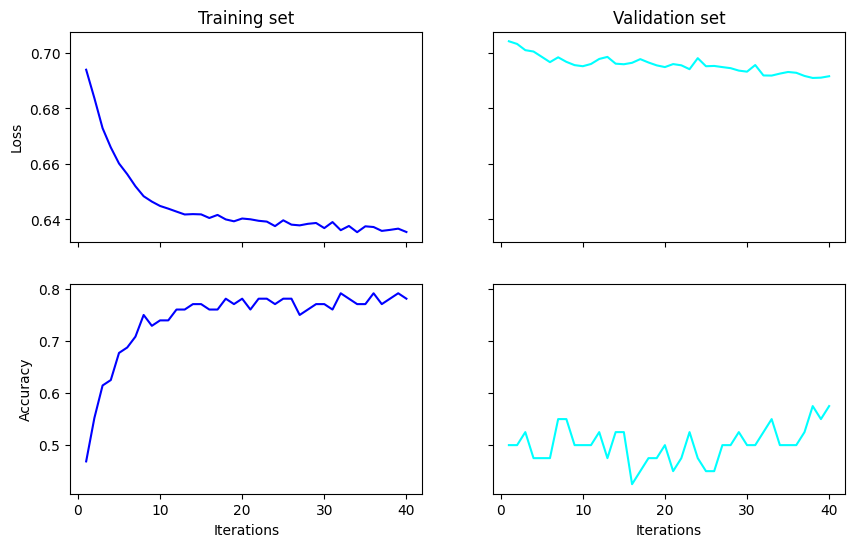

In [22]:
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(
    2, 2, sharex=True, sharey='row', figsize=(10, 6)
)
ax_tl.set_title('Training set')
ax_tr.set_title('Validation set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

range_ = np.arange(1, trainer.epochs+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color="blue")
ax_bl.plot(range_, trainer.train_eval_results['acc'], color="blue")
ax_tr.plot(range_, trainer.val_costs, color="cyan")
ax_br.plot(range_, trainer.val_eval_results['acc'], color="cyan")

In [59]:
# Plot the accuracy per number of sentences
full_dataset = QADataset(
    data=[entry["circuits"] for entry in dataset],
    targets=[entry["target"] for entry in dataset],
    batch_size=1, shuffle=False
)
accs = []
for x, y in tqdm(full_dataset):
    pred = trainer.model(x)
    accs.append(acc(pred, y))

len(accs), sum(accs) / len(accs)

100%|██████████| 408/408 [08:53<00:00,  1.31s/it]


(408, tensor(0.5735))

In [60]:
# Acc plotting util
def plot_acc(ax, bounds, condition, train_threshold, valid_threshold, style="solid"):
    x = np.arange(*bounds)
    y_train = np.array([
        sum(ys) / len(ys) if len(ys) > 0 else None
        for val in x
        for ys in [[acc.item() for i, acc in enumerate(accs) if condition(dataset[i], val) and i in train_ids]]
    ])
    y_valid = np.array([
        sum(ys) / len(ys) if len(ys) > 0 else None
        for val in x
        for ys in [[acc.item() for i, acc in enumerate(accs) if condition(dataset[i], val) and i in valid_ids]]
    ])
    y_test = np.array([
        sum(ys) / len(ys) if len(ys) > 0 else None
        for val in x
        for ys in [[acc.item() for i, acc in enumerate(accs) if condition(dataset[i], val) and i in test_ids]]
    ])
    y_other = np.array([
        sum(ys) / len(ys) if len(ys) > 0 else None
        for val in x
        for ys in [[acc.item() for i, acc in enumerate(accs) if condition(dataset[i], val) and i in other_ids]]
    ])
    ax.axvline(round(train_threshold), c="cyan", label="Validation")
    ax.axvline(round(valid_threshold), c="red", label="Test")
    ax.text(bounds[0] - 0.4, 1.01, "Train", c="blue")
    ax.text(round(train_threshold) + 0.1, 1.01, "Validation", c="cyan")
    ax.text(round(valid_threshold) + 0.1, 1.01, "Test", c="red")
    ax.plot(x, y_train, c="blue", linestyle=style)
    ax.plot(x, y_valid, c="cyan", linestyle=style)
    ax.plot(x, y_test, c="red", linestyle=style)
    ax.plot(x, y_other, c="k", linestyle=style)
    ax.set_xlim(bounds[0] - 0.5, bounds[1] - 0.5)
    ax.set_ylim(min(0.5, *([acc - 0.1 for acc in y_train + y_valid + y_test + y_other if acc])), 1.02)
    return ax

TypeError: unsupported operand type(s) for +: 'float' and 'NoneType'

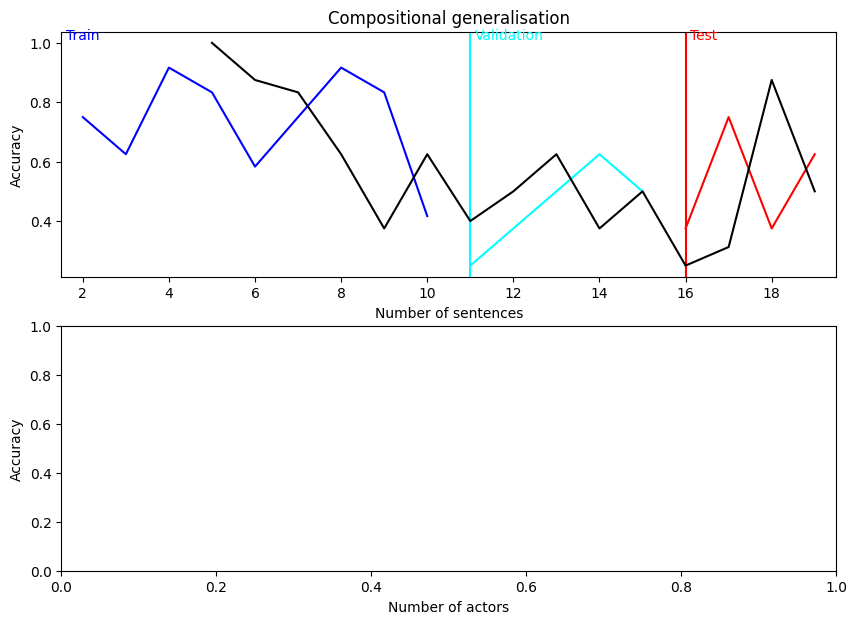

In [61]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(10, 7))
ax.set_title('Compositional generalisation')
ax.set_xlabel('Number of sentences')
ax2.set_xlabel('Number of actors')
ax.set_ylabel('Accuracy')
ax2.set_ylabel('Accuracy')

plot_acc(
    ax,
    (min_sents, max_sents),
    lambda entry, value: entry["n_sentences"] == value,
    train_threshold, valid_threshold
)
plot_acc(
    ax2,
    (min_actors, max_actors),
    lambda entry, value: entry["n_actors"] == value,
    n_actor_train_cutoff, n_actor_valid_cutoff
)

<Axes: title={'center': 'Accuracy per number of sentences, per entangled direction.'}, xlabel='Number of sentences', ylabel='Accuracy'>

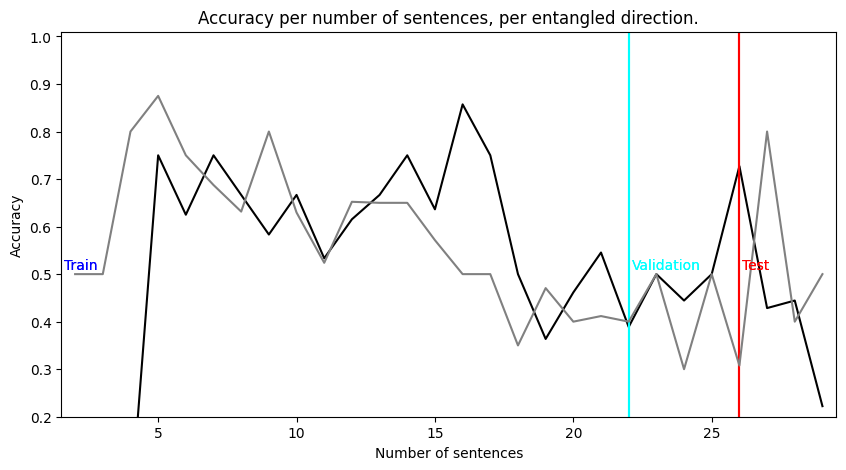

In [165]:
# Plot accuracy split by whether the final directions are entangled
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(10, 7))

fig.set_title("Accuracy per number of sentences, per entangled direction.")
ax.set_title("Entangled.")
ax2.set_title("Not entangled.")
ax.set_xlabel('Number of sentences')
ax2.set_xlabel('Number of sentences')
ax.set_ylabel('Accuracy')
ax2.set_ylabel('Accuracy')

plot_acc(
    ax,
    (min_sents, max_sents),
    lambda entry, value: entry["n_sentences"] == value and entry["entangled"],
    train_threshold, valid_threshold,
    style="solid"
)
plot_acc(
    ax2,
    (min_sents, max_sents),
    lambda entry, value: entry["n_sentences"] == value and not entry["entangled"],
    train_threshold, valid_threshold,
    style="dashed"
)